In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
#import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold, cross_val_score, train_test_split 

from sklearn import cross_validation
from sklearn.learning_curve import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from time import time

Load File (Dataset) into DataFrame 

In [10]:
xls_file = pd.ExcelFile('SMSlist.xlsx')
df = xls_file.parse('Sheet1')

In [11]:
print df.head()
print type(df)

df['stamp'] = df['stamp'].map({'ham': 'notspam', 'spam': 'spam'})
print df.head()

                                          smscontent stamp  link  numbercounts
0  Viettel khuyen mai 50% danh cho thue bao tra t...  spam     1             0
1  http://www.smscaster.com VASCARA khuyen mai: g...  spam     0             1
2                 hom nay anh co an com o nha khong?   ham     0             0
3  A/C than, 9/5 toi Danh ca KHANH LY voi cac ca ...  spam     0             1
4  IVY moda: chuong trinh "Summer First Sale" GG ...  spam     1             0
<class 'pandas.core.frame.DataFrame'>
                                          smscontent    stamp  link  \
0  Viettel khuyen mai 50% danh cho thue bao tra t...     spam     1   
1  http://www.smscaster.com VASCARA khuyen mai: g...     spam     0   
2                 hom nay anh co an com o nha khong?  notspam     0   
3  A/C than, 9/5 toi Danh ca KHANH LY voi cac ca ...     spam     0   
4  IVY moda: chuong trinh "Summer First Sale" GG ...     spam     1   

   numbercounts  
0             0  
1             1  
2      

In [13]:
#Pre-processing: Add features: Text Length and Numeric/Alphabet ratio

df['length'] = df['smscontent'].map(lambda text: len(text))
df['ratio']= df['smscontent'].map(lambda s: sum(c.isdigit() for c in s)/(sum(c.isalpha() for c in s)*1.0))
df['numbercounts'] = df['smscontent'].map(lambda s: sum(c.isdigit() for c in s))
print df.head()

                                          smscontent    stamp  link  \
0  Viettel khuyen mai 50% danh cho thue bao tra t...     spam     1   
1  http://www.smscaster.com VASCARA khuyen mai: g...     spam     0   
2                 hom nay anh co an com o nha khong?  notspam     0   
3  A/C than, 9/5 toi Danh ca KHANH LY voi cac ca ...     spam     0   
4  IVY moda: chuong trinh "Summer First Sale" GG ...     spam     1   

   numbercounts  length     ratio  
0            12     160  0.115385  
1            21     152  0.230769  
2             0      34  0.000000  
3            12     163  0.112150  
4            11     119  0.142857  


count     99.000000
mean     108.888889
std       53.266540
min       14.000000
25%       53.000000
50%      132.000000
75%      157.500000
max      188.000000
Name: length, dtype: float64

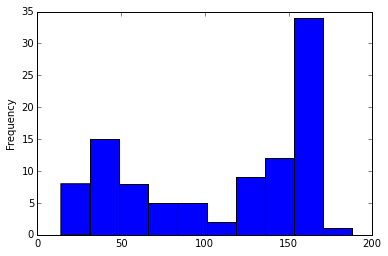

In [14]:
#Little move into the data
df.length.plot(bins=10, kind='hist')
df.length.describe()

count    99.000000
mean      0.297848
std       1.094520
min       0.000000
25%       0.000000
50%       0.121212
75%       0.232732
max       8.818182
Name: ratio, dtype: float64

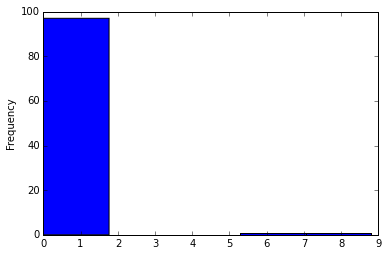

In [15]:
df.ratio.plot(bins=5, kind= 'hist')
df.ratio.describe()

In [110]:
#print length messages
print list(df.smscontent[df.length > 170])

[u'INTERNET FPT chinh thuc cung cap dich vu INTERNET CAP QUANG toc do cao toi ho gia dinh. Nhan dip nay nhieu uu dai lon: mien phi lap dat, tang modem wifi\u2026 LH Ms Hanh tu van 24/7 xin cam on.']


In [18]:
#print message with lot of numerics
print list(df.smscontent[df.ratio > 5])

[u'ban 091564198=3,5tr va 0912721866 0911703799 01242588886 01236137979=599k. LH 0914282626', u'Ban 0956666156=3,5 tr va 01229926699=650k 0888118999=1.4 0888180995=1.4 0888553919=1.4 0925666458=1.1 0888180695=1.4. Goi 01298212121']


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff428d24f90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7ff428c41090>], dtype=object)

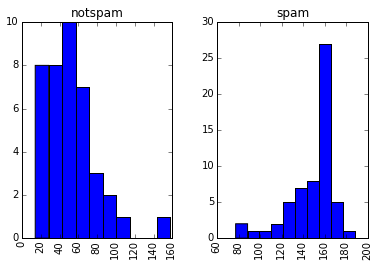

In [19]:
#Is there any difference in message length between spam and notspam
df.hist(column='length', by='stamp', bins=10)

count    99.000000
mean     12.929293
std      15.415505
min       0.000000
25%       0.000000
50%      10.000000
75%      20.500000
max      97.000000
Name: numbercounts, dtype: float64

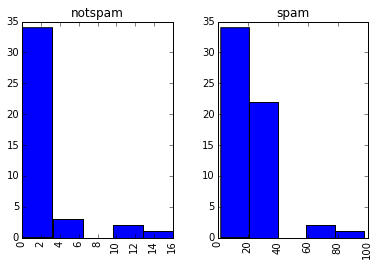

In [20]:
#Is there any difference in numeric counts between spam and notspam
df.hist(column='numbercounts', by='stamp', bins=5)
df.numbercounts.describe()

Function for Text Processing: Simple Operations include converting upper-case to lower-case, tokenize the text based on single unigram

In [21]:
def features(message):
    message = unicode(message).lower() #upper-case into lower-case
    words = TextBlob(message).words #tokenize the message in single unigram
    d={}
    for m in words:
        d[m] = d.get(m, 0) + 1
    return d

In [22]:
df.smscontent.head(10).apply(features)

0    {u'thoai': 1, u'ngay': 1, u'truoc': 1, u'thue'...
1    {u'tat': 1, u'www.smscaster.com': 1, u'san': 1...
2    {u'co': 1, u'hom': 1, u'anh': 1, u'o': 1, u'an...
3    {u'hoai': 1, u'a/c': 3, u've': 2, u'sac': 1, u...
4    {u'1.5': 1, u'san': 1, u'summer': 1, u'gg': 1,...
5    {u'em': 1, u'goi': 1, u'vao': 1, u'anh': 1, u'...
6    {u'em': 1, u'chua': 1, u'an': 1, u'com': 1, u'...
7    {u'em': 1, u'co': 1, u'toi': 1, u'khong': 1, u...
8    {u'a': 1, u'lam': 1, u'toan': 1, u'oi': 1, u'i...
9    {u'sodep86.com': 1, u'nha': 1, u'lien': 1, u'r...
Name: smscontent, dtype: object

Split the data into training and testing and create the model based on the training data

In [115]:
msg_train, msg_test, label_train, label_test = train_test_split(df['smscontent'], df['stamp'], test_size = 0.2)


In [116]:
transformer = CountVectorizer(analyzer=features).fit(msg_train)
print transformer
print len(transformer.vocabulary_)
print transformer.get_feature_names()[200]

CountVectorizer(analyzer=<function features at 0x7ff428b9b668>, binary=False,
        decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)
692
cau


In [117]:
messages= transformer.transform(msg_train)
print 'sparse matrix shape:', messages.shape
print 'number of non-zeros:', messages.nnz
print 'sparsity: %.2f%%' % (100.0 * messages.nnz / (messages.shape[0] * messages.shape[1]))
print 'sparse matrix shape:', messages.shape
print 'number of non-zeros:', messages.nnz
print 'sparsity: %.2f%%' % (100.0 * messages.nnz / (messages.shape[0] * messages.shape[1]))

sparse matrix shape: (79, 692)
number of non-zeros: 1613
sparsity: 2.95%
sparse matrix shape: (79, 692)
number of non-zeros: 1613
sparsity: 2.95%


Text Learning based on TF-IDF

In [118]:
tfidf_transformer = TfidfTransformer().fit(messages)
messages_tfidf = tfidf_transformer.transform(messages)
print tfidf_transformer
print messages_tfidf

TfidfTransformer(norm=u'l2', smooth_idf=True, sublinear_tf=False,
         use_idf=True)
  (0, 654)	0.205183572676
  (0, 645)	0.240777152316
  (0, 635)	0.193724999393
  (0, 549)	0.144658836146
  (0, 533)	0.144658836146
  (0, 528)	0.205183572676
  (0, 505)	0.240777152316
  (0, 476)	0.205183572676
  (0, 450)	0.15323717713
  (0, 442)	0.21995624296
  (0, 388)	0.130883297791
  (0, 374)	0.240777152316
  (0, 304)	0.21995624296
  (0, 298)	0.184362663321
  (0, 295)	0.133996413397
  (0, 248)	0.169589993037
  (0, 239)	0.169589993037
  (0, 237)	0.15323717713
  (0, 216)	0.193724999393
  (0, 211)	0.184362663321
  (0, 198)	0.158131419753
  (0, 194)	0.193724999393
  (0, 124)	0.205183572676
  (0, 72)	0.240777152316
  (0, 36)	0.240777152316
  :	:
  (78, 556)	0.180881216541
  (78, 535)	0.164748658244
  (78, 523)	0.205373353657
  (78, 489)	0.131514899016
  (78, 417)	0.138905835201
  (78, 415)	0.147647457313
  (78, 409)	0.172139594429
  (78, 392)	0.224813856563
  (78, 376)	0.158346338107
  (78, 319)	0.1808

All about Machine Learning as Classifier

In [119]:

#spam_detector = MultinomialNB().fit(messages_tfidf, label_train) #effective training (apart from pre-processing)
t0 = time()
spam_detector = LinearSVC().fit(messages_tfidf, label_train)
print "training time:", round(time()-t0, 3), "s"
#spam_detector = DecisionTreeClassifier().fit(messages_tfidf, label_train) 
#spam_detector = RandomForestClassifier().fit(messages_tfidf, label_train)  


training time: 0.003 s


messages_test= transformer.transform(msg_test)
messages_test_tfidf= tfidf_transformer.transform(messages_test)
print messages_test_tfidf
predicted_test = spam_detector.predict(messages_test_tfidf)
print predicted_test

Test on test set


In [120]:
messages_test= transformer.transform(msg_test)
t1=time()
predictions = spam_detector.predict(messages_test)
print "prediction time:", round(time()-t1, 5), "s"

print predictions
predictions == label_test

prediction time: 0.00028 s
['spam' 'notspam' 'spam' 'spam' 'spam' 'notspam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'notspam' 'notspam' 'notspam' 'spam' 'spam' 'notspam'
 'notspam' 'notspam' 'spam']


60     True
88     True
77     True
11     True
35     True
27     True
71     True
42     True
75     True
66     True
62     True
80     True
95     True
17     True
9      True
72     True
85     True
48    False
25     True
18     True
Name: stamp, dtype: bool

Evaluation on Test Set

In [121]:
print "Accuracy: ", spam_detector.score(messages_test, label_test)
predictions = spam_detector.predict(messages_test)
print confusion_matrix(label_test, predictions)
print '(row=expected, col=predicted)'
print classification_report(label_test, predictions)

Accuracy:  0.95
[[ 7  0]
 [ 1 12]]
(row=expected, col=predicted)
             precision    recall  f1-score   support

    notspam       0.88      1.00      0.93         7
       spam       1.00      0.92      0.96        13

avg / total       0.96      0.95      0.95        20



Predict a new message

In [122]:
examples = ['Ban chung cu cao cap gia re', 'toi nay di choi de']
example_counts = transformer.transform(examples)
predictions = spam_detector.predict(example_counts)
predictions


array(['spam', 'notspam'], dtype=object)

Performance Evaluation and Parameter Tuning: remain to be seen!

Produce a predictor: The final (optimal found via parameter tuning) predictor can be serialized to disk, so that the next time we want to use it, we can skip all training and use the trained model directly. Interesting!



In [123]:
# store the spam detector to disk after training
with open('spam_detector.pkl', 'wb') as fout:
    cPickle.dump(spam_detector, fout)

# ...and load it back, whenever needed, possibly on a different machine
spam_detector_reloaded = cPickle.load(open('spam_detector.pkl')) 

In [124]:
t1 = time()
print 'before:', spam_detector.predict(example_counts)
print "prediction time:", round(time()-t1, 3), "s"
print 'after:', spam_detector_reloaded.predict(example_counts)

before: ['spam' 'notspam']
prediction time: 0.001 s
after: ['spam' 'notspam']


Parameter Tuning using GridSearchCV

In [125]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
t1 = time()
clf.fit(messages_tfidf, label_train)
print "training time for grid of parameters", round(time() -t1, 3), "s"
print "best parameters found", clf.best_params_

clf.predict(example_counts)

training time for grid of parameters 0.061 s
best parameters found {'kernel': 'linear', 'C': 10}


array(['notspam', 'notspam'], dtype=object)

K-fold cross-validation

In [126]:
cv = KFold( len(df['smscontent']), 5, shuffle=True )
print cv

sklearn.cross_validation.KFold(n=99, n_folds=5, shuffle=True, random_state=None)


In [127]:
x= list(df['smscontent'])
y = list(df['stamp'])

accuracy = list()
for train_indices, test_indices in cv:
    
    
    msg_train = [x[ii] for ii in train_indices]
    msg_test = [x[ii] for ii in test_indices]
    label_test = [y[ii] for ii in test_indices]
    label_train = [y[ii] for ii in train_indices]
    
    ttrain= time()
    transformer = CountVectorizer(analyzer=features).fit(msg_train)
    messages= transformer.transform(msg_train)
    tfidf_transformer = TfidfTransformer().fit(messages)
    messages_tfidf = tfidf_transformer.transform(messages)
    
    spam_detector = LinearSVC().fit(messages_tfidf, label_train)
    print "training time:", round(time()-ttrain, 3), "s"
    
    messages_test= transformer.transform(msg_test)
    ttest=time()
    predictions = spam_detector.predict(messages_test)
    print "prediction time:", round(time()-ttest, 5), "s"

    print "accuracy", spam_detector.score(messages_test, label_test)
    accuracy.append(spam_detector.score(messages_test, label_test))
    
    

#print accuracy
print "mean accuracy", np.asarray(accuracy).mean()
print "standard deviation", np.asarray(accuracy).std()

training time: 0.157 s
prediction time: 0.00011 s
accuracy 1.0
training time: 0.13 s
prediction time: 0.00012 s
accuracy 0.9
training time: 0.128 s
prediction time: 0.00012 s
accuracy 0.95
training time: 0.133 s
prediction time: 0.00012 s
accuracy 0.95
training time: 0.134 s
prediction time: 0.00015 s
accuracy 0.947368421053
mean accuracy 0.949473684211
standard deviation 0.0316402912951


What could be done next: A lot lot of things!!!